In [1]:
!mkdir /content/data
!unzip /content/drive/MyDrive/Kaggle/archive.zip -d /content

Archive:  /content/drive/MyDrive/Kaggle/archive.zip
  inflating: /content/COVID_CT/Infected/(1).jpg  
  inflating: /content/COVID_CT/Infected/(10).jpg  
  inflating: /content/COVID_CT/Infected/(100).jpg  
  inflating: /content/COVID_CT/Infected/(101).jpg  
  inflating: /content/COVID_CT/Infected/(102).jpg  
  inflating: /content/COVID_CT/Infected/(103).jpg  
  inflating: /content/COVID_CT/Infected/(104).jpg  
  inflating: /content/COVID_CT/Infected/(105).jpg  
  inflating: /content/COVID_CT/Infected/(106).jpg  
  inflating: /content/COVID_CT/Infected/(107).jpg  
  inflating: /content/COVID_CT/Infected/(108).jpg  
  inflating: /content/COVID_CT/Infected/(109).jpg  
  inflating: /content/COVID_CT/Infected/(11).jpg  
  inflating: /content/COVID_CT/Infected/(110).jpg  
  inflating: /content/COVID_CT/Infected/(111).jpg  
  inflating: /content/COVID_CT/Infected/(112).jpg  
  inflating: /content/COVID_CT/Infected/(113).jpg  
  inflating: /content/COVID_CT/Infected/(114).jpg  
  inflating: /co

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

%cd COVID_CT

/content/COVID_CT


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [4]:
infected_folder = 'Infected'
infected_images = load_images_from_folder(infected_folder)
n_infected_folder = 'Not_Infected'
n_infected_images = load_images_from_folder(n_infected_folder)

In [5]:
h, w = n_infected_images[0].shape
h, w

(512, 512)

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array

infected = img_to_array(infected_images)
n_infected = img_to_array(n_infected_images)

## 대비 제한 적응 히스토그램 평활화(CLAHE: Contrast-limited adaptive histogram equalization)
+ 명암 값이 좁은 곳에 집중분포 될 때 골고루 재분배 해주는 것

In [7]:
clahe = cv2.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    img = np.uint8(img*255)
    clahe_img = clahe.apply(img)

    if len(axes) > 0:
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
        if len(axes) > 2:
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label='CLAHE Enhanced CT scan')

    return (clahe_img)

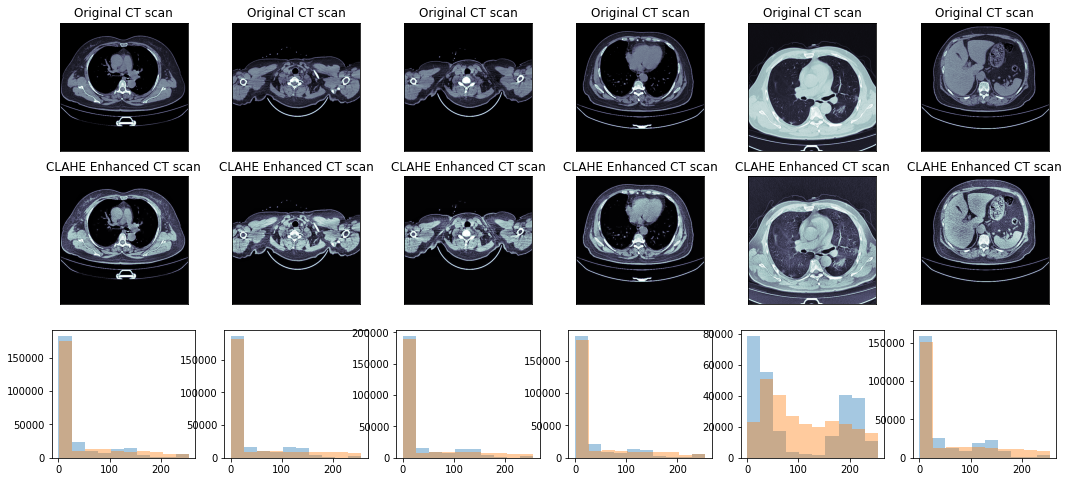

In [8]:
fig, axes = plt.subplots(3, 6, figsize=(18,8))  
img_size = 512

for i in range(0,6):
    img = cv2.resize(infected[i+10], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, i]))

# 이미지 자르기(Cropping Images)
+ 속도 개선에도 도움, 분류에 방해되는 부분 제거 등 다양한 효과

In [9]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv2.filter2D(img, -1, kernel)
    
    ret, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv2.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

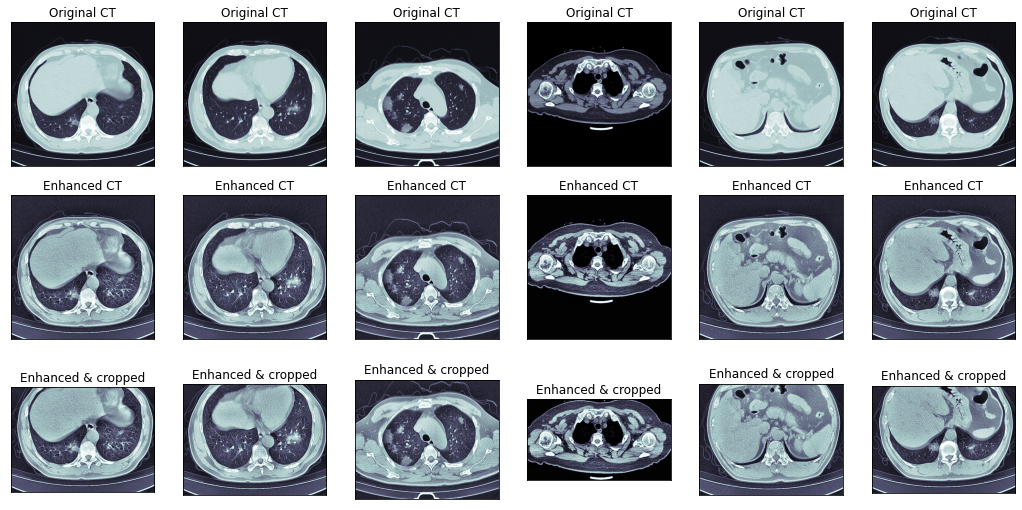

In [10]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for i in range(0,6):
    img = cv2.resize(infected[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,i].imshow(img, cmap='bone')
    axes[0,i].set_title('Original CT')
    axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,i].imshow(clahe_img, cmap='bone')
    axes[1,i].set_title('Enhanced CT')
    axes[1,i].set_xticks([]); axes[1,i].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,i].imshow(cropped_img, cmap='bone')
    axes[2,i].set_title('Enhanced & cropped')
    axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

In [11]:
infected_f = []

for i in range(infected.shape[0]):
    img_ct = cv2.resize(infected[i], dsize=(img_size, img_size), 
                        interpolation=cv2.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    infected_f.append(cropped_ct)

In [12]:
n_infected_f = []

for i in range(n_infected.shape[0]):
    img_ct = cv2.resize(n_infected[i], dsize=(img_size, img_size), 
                        interpolation=cv2.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    n_infected_f.append(cropped_ct)

In [13]:
import tqdm

num_pix = 512
del_lst = []
for ii in tqdm.tqdm(range(len(infected_f))) :
    try :
        infected_f[ii] = cv2.resize(infected_f[ii], dsize=(num_pix, num_pix), interpolation=cv2.INTER_AREA)
        infected_f[ii] = np.reshape(infected_f[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del infected_f[idx]

100%|██████████| 501/501 [00:00<00:00, 2064.01it/s]


In [14]:
num_pix = 512
del_lst = []
for ii in tqdm.tqdm(range(len(n_infected_f))) :
    try :
        n_infected_f[ii] = cv2.resize(n_infected_f[ii], dsize=(num_pix, num_pix), interpolation=cv2.INTER_AREA)
        n_infected_f[ii] = np.reshape(n_infected_f[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del n_infected_f[idx]

100%|██████████| 550/550 [00:00<00:00, 2031.11it/s]


Text(0.5, 1.0, 'Enhanced & Cropped CT')

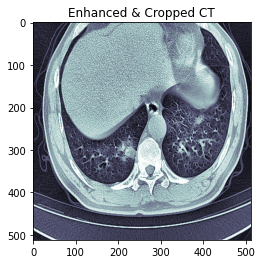

In [15]:
plt.figure()

plt.imshow(infected_f[0][:,:,0], cmap='bone')
plt.title("Enhanced & Cropped CT")

# 데이터 저장

In [16]:
import random
random.seed(12345)

random.shuffle(n_infected_images)
random.shuffle(infected_images)

In [17]:
itr = round(501*0.5)
ival = round(501*0.1)
ite = round(501*0.4)

ntr = round(550*0.5)
nval = round(550*0.1)
nte = round(550*0.4)

In [18]:
covid_dir = 'Covid_CT'
os.mkdir(covid_dir)

In [19]:
# train, val, test folder
train_dir = './Covid_CT/train'
val_dir = './Covid_CT/val'
test_dir = './Covid_CT/test'

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

# infected folder
in_train = './Covid_CT/train/infected'
in_val = './Covid_CT/val/infected'
in_test = './Covid_CT/test/infected'

os.mkdir(in_train)
os.mkdir(in_val)
os.mkdir(in_test)

#not infected folder
not_in_train = './Covid_CT/train/Not_infected'
not_in_val = './Covid_CT/val/Not_infected'
not_in_test = './Covid_CT/test/Not_infected'

os.mkdir(not_in_train)
os.mkdir(not_in_val)
os.mkdir(not_in_test)

In [20]:
def infected_images_to_folder(infected_images, train_dir, val_dir, test_dir):
    for i in range(len(infected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, itr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), infected_images[i])
        elif i in range(itr+1, itr+ival+1):
            cv2.imwrite(os.path.join(val_dir, img_name), infected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), infected_images[i])

In [21]:
def not_infected_images_to_folder(n_intected_images, train_dir, val_dir, test_dir):
    for i in range(len(n_intected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, ntr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), n_intected_images[i])
        elif i in range(ntr+1, ntr+nval+1):
            cv2.imwrite(os.path.join(val_dir, img_name), n_intected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), n_intected_images[i])

In [22]:
infected_images_to_folder(infected_images, './Covid_CT/train/infected', './Covid_CT/val/infected', './Covid_CT/test/infected')
not_infected_images_to_folder(n_infected_images, './Covid_CT/train/Not_infected', './Covid_CT/val/Not_infected', './Covid_CT/test/Not_infected')

# CNN4
+ 1, 2, 3 조건은 동일하게 적용
+ 히스토그램 평활화 진행한 데이터 사용

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

validation_generator = validate_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

Found 527 images belonging to 2 classes.
Found 105 images belonging to 2 classes.
Found 419 images belonging to 2 classes.


In [25]:
IMAGE_ROWS = 150
IMAGE_COLS = 150
BATCH_SIZE = 30
IMAGE_SHAPE = (IMAGE_ROWS,IMAGE_COLS,1)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

model_CNN4 = models.Sequential()
model_CNN4.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE))
model_CNN4.add(layers.MaxPool2D((2,2)))
model_CNN4.add(layers.Dropout(0.8))
model_CNN4.add(layers.Conv2D(64, (3,3), activation='relu'))
model_CNN4.add(layers.MaxPool2D((2,2)))
model_CNN4.add(layers.Dropout(0.5))
model_CNN4.add(layers.Flatten())
model_CNN4.add(layers.Dense(16, activation='relu'))
model_CNN4.add(layers.Dense(1, activation='sigmoid'))

model_CNN4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)            

In [40]:
from tensorflow.keras import optimizers

model_CNN4.compile(optimizer=optimizers.Adam(learning_rate=1e-4), # 'rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

In [45]:
history = model_CNN4.fit_generator(train_generator, steps_per_epoch=15, epochs=20, validation_data = validation_generator, validation_steps = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 3s 187ms/step - loss: 0.6374 - acc: 0.6201 - val_loss: 0.6540 - val_acc: 0.5667
Epoch 2/20
15/15 [==============================] - 3s 179ms/step - loss: 0.6511 - acc: 0.6087 - val_loss: 0.6526 - val_acc: 0.6333
Epoch 3/20
15/15 [==============================] - 3s 175ms/step - loss: 0.6477 - acc: 0.6087 - val_loss: 0.6692 - val_acc: 0.6000
Epoch 4/20
15/15 [==============================] - 3s 176ms/step - loss: 0.6354 - acc: 0.6247 - val_loss: 0.6686 - val_acc: 0.5667
Epoch 5/20
15/15 [==============================] - 3s 180ms/step - loss: 0.6104 - acc: 0.6110 - val_loss: 0.6658 - val_acc: 0.6667
Epoch 6/20
15/15 [==============================] - 3s 177ms/step - loss: 0.6109 - acc: 0.6224 - val_loss: 0.6728 - val_acc: 0.5667
Epoch 7/20
15/15 [==============================] - 3s 176ms/step - loss: 0.6219 - acc: 0.6224 - val_loss: 0.6693 - val_acc: 0.5333
Epoch 8/20
15/15 [==============================] - 3s 175ms/step - loss: 0.

In [46]:
tr_score = model_CNN4.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train Loss : 0.6008
Train Accuracy : 0.6679


In [47]:
te_score = model_CNN4.evaluate(test_generator)
print('Test Loss : {:.4f}'.format(te_score[0]))
print('Test Accuracy : {:.4f}'.format(te_score[1]))

14/14 [==============================] - 1s 93ms/step - loss: 0.5925 - acc: 0.6874
Test Loss : 0.5925
Test Accuracy : 0.6874


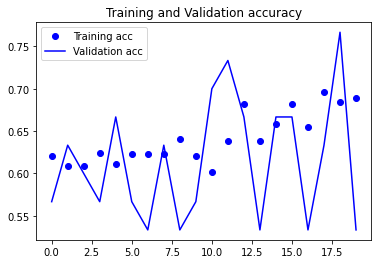

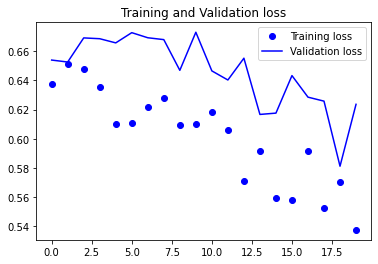

In [48]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# CNN5 - Inception-v3
+ X-ray Classification에서도 사용되는 모델, 흑백 이미지 분류에 많이 사용, GoogleNet의 기반이 되는 모델

In [49]:
IMAGE_ROWS = 150
IMAGE_COLS = 150
IMAGE_SHAPE = (IMAGE_ROWS,IMAGE_COLS,1)

In [50]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Input, Dense, Flatten
from tensorflow.keras import models

inputs = Input(IMAGE_SHAPE)
conv1x1 = Conv2D(1, kernel_size=(1,1), padding='same', activation='relu')(inputs)
conv3x3 = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(inputs)
conv5x5 = Conv2D(1, kernel_size=(5,5), padding='same', activation='relu')(inputs)
pooling = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)

conv1x1_out = Flatten()(conv1x1)
conv3x3_out = Flatten()(conv3x3)
conv5x5_out = Flatten()(conv5x5)
pooling_out = Flatten()(pooling)

concat = concatenate([conv1x1_out, conv3x3_out, conv5x5_out, pooling_out])
output_layer = Dense(1, activation='sigmoid')(concat) 

model_CNN5 = models.Model(inputs, output_layer)


model_CNN5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 150, 1)  2           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 150, 150, 2)  20          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 150, 150, 1)  26          input_1[0][0]                    
______________________________________________________________________________________________

In [51]:
from tensorflow.keras import optimizers

model_CNN5.compile(optimizer=optimizers.Adam(learning_rate=1e-4), # 'rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

In [55]:
history = model_CNN5.fit_generator(train_generator, steps_per_epoch=15, epochs=10, validation_data = validation_generator, validation_steps = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
15/15 [==============================] - 3s 172ms/step - loss: 0.6566 - acc: 0.5881 - val_loss: 0.6575 - val_acc: 0.6667
Epoch 2/10
15/15 [==============================] - 2s 166ms/step - loss: 0.6145 - acc: 0.6201 - val_loss: 0.5410 - val_acc: 0.8000
Epoch 3/10
15/15 [==============================] - 2s 166ms/step - loss: 0.6305 - acc: 0.5973 - val_loss: 0.6741 - val_acc: 0.5333
Epoch 4/10
15/15 [==============================] - 2s 165ms/step - loss: 0.6363 - acc: 0.6156 - val_loss: 0.6033 - val_acc: 0.5333
Epoch 5/10
15/15 [==============================] - 2s 162ms/step - loss: 0.5975 - acc: 0.6453 - val_loss: 0.4984 - val_acc: 0.7667
Epoch 6/10
15/15 [==============================] - 2s 165ms/step - loss: 0.6234 - acc: 0.6339 - val_loss: 0.5303 - val_acc: 0.8000
Epoch 7/10
15/15 [==============================] - 2s 164ms/step - loss: 0.6087 - acc: 0.6339 - val_loss: 0.4859 - val_acc: 0.7333
Epoch 8/10
15/15 [==============================] - 2s 164ms/step - loss: 0.

In [56]:
tr_score = model_CNN5.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train Loss : 0.5776
Train Accuracy : 0.6869


In [57]:
te_score = model_CNN5.evaluate(test_generator)
print('Test Loss : {:.4f}'.format(te_score[0]))
print('Test Accuracy : {:.4f}'.format(te_score[1]))

14/14 [==============================] - 1s 91ms/step - loss: 0.5309 - acc: 0.7064
Test Loss : 0.5309
Test Accuracy : 0.7064


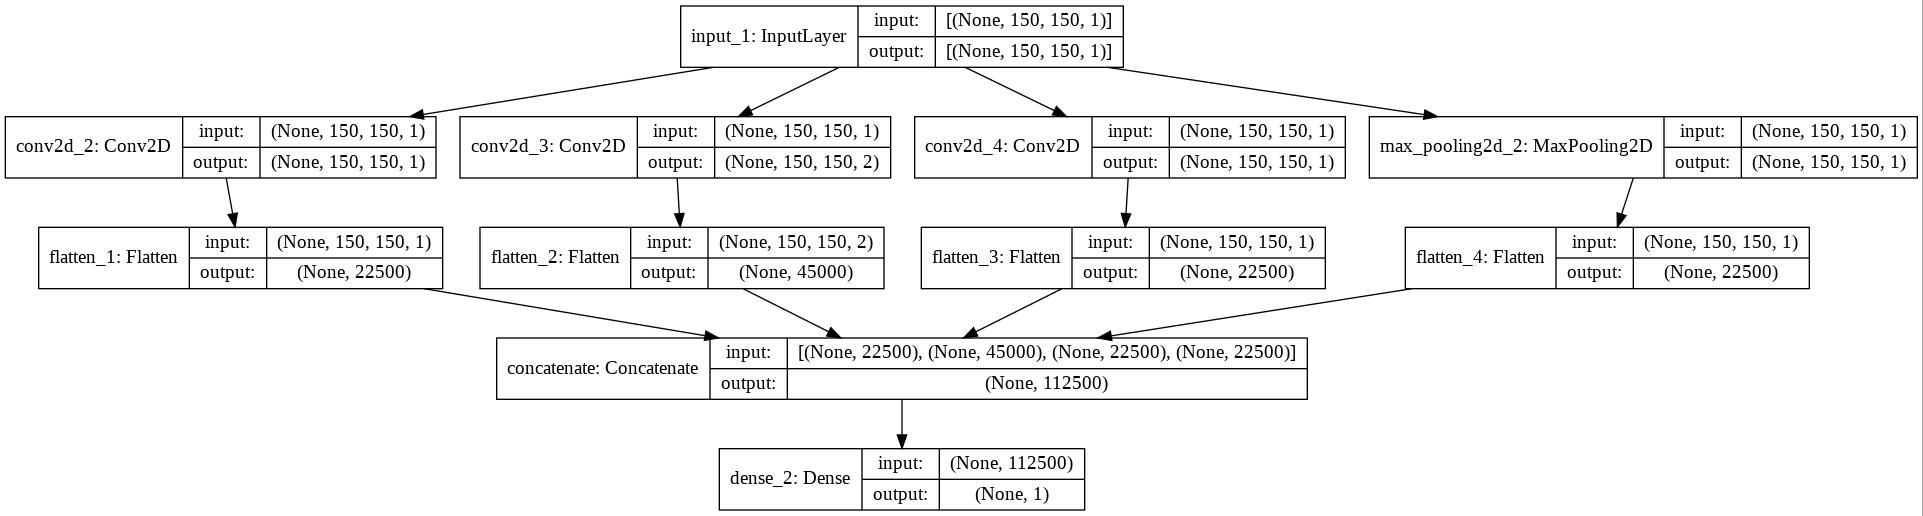

In [58]:
from tensorflow.keras.utils import plot_model

plot_model(model_CNN5, to_file='5.jpg', show_shapes=True)

# CNN6 - Reduced Inception-v3
+ Convolution1x1 레이어를 이용하여 dimension을 줄여, AlexNet보다 12배만큼 적은 파라미터로 훈련

In [60]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Input, Dense, Flatten
from tensorflow.keras import models

inputs = Input(IMAGE_SHAPE)
conv1x1 = Conv2D(1, kernel_size=(7,7), padding='same', activation='relu')(inputs)
conv3x3_reduce = Conv2D(1, kernel_size=(1,1), padding='same', activation='relu')(inputs)
conv3x3 = Conv2D(1, kernel_size=(3,3), padding='same', activation='relu')(conv3x3_reduce)
conv5x5_reduce = Conv2D(1, kernel_size=(1,1), padding='same', activation='relu')(inputs)
conv5x5 = Conv2D(1, kernel_size=(5,5), padding='same', activation='relu')(conv5x5_reduce)
pooling = MaxPooling2D((4,4), strides=(1,1), padding='same')(inputs)
pool_proj = Conv2D(1, kernel_size=(1,1), padding='same', activation='relu')(pooling)

conv1x1_out = Flatten()(conv1x1)
conv3x3_out = Flatten()(conv3x3)
conv5x5_out = Flatten()(conv5x5)
pooling_out = Flatten()(pool_proj)

concat = concatenate([conv1x1_out, conv3x3_out, conv5x5_out, pooling_out])
output_layer = Dense(1, activation='sigmoid')(concat) 

model_CNN6 = models.Model(inputs, output_layer)
model_CNN6.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 150, 150, 1)  2           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 150, 150, 1)  2           input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 150, 150, 1)  0           input_3[0][0]                    
____________________________________________________________________________________________

In [61]:
from tensorflow.keras import optimizers

model_CNN6.compile(optimizer=optimizers.Adam(learning_rate=1e-4), # 'rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

In [63]:
history = model_CNN6.fit_generator(train_generator, steps_per_epoch=15, epochs=5, validation_data = validation_generator, validation_steps = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
15/15 [==============================] - 3s 177ms/step - loss: 0.6426 - acc: 0.5835 - val_loss: 0.5766 - val_acc: 0.7667
Epoch 2/5
15/15 [==============================] - 3s 168ms/step - loss: 0.6427 - acc: 0.5927 - val_loss: 0.5642 - val_acc: 0.7333
Epoch 3/5
15/15 [==============================] - 3s 169ms/step - loss: 0.6444 - acc: 0.6384 - val_loss: 0.5897 - val_acc: 0.7000
Epoch 4/5
15/15 [==============================] - 3s 168ms/step - loss: 0.6452 - acc: 0.5767 - val_loss: 0.6029 - val_acc: 0.6667
Epoch 5/5
15/15 [==============================] - 3s 168ms/step - loss: 0.6022 - acc: 0.6613 - val_loss: 0.5887 - val_acc: 0.6000


In [64]:
tr_score = model_CNN6.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train Loss : 0.6241
Train Accuracy : 0.6300


In [65]:
te_score = model_CNN6.evaluate(test_generator)
print('Test Loss : {:.4f}'.format(te_score[0]))
print('Test Accuracy : {:.4f}'.format(te_score[1]))

14/14 [==============================] - 1s 93ms/step - loss: 0.5960 - acc: 0.6802
Test Loss : 0.5960
Test Accuracy : 0.6802


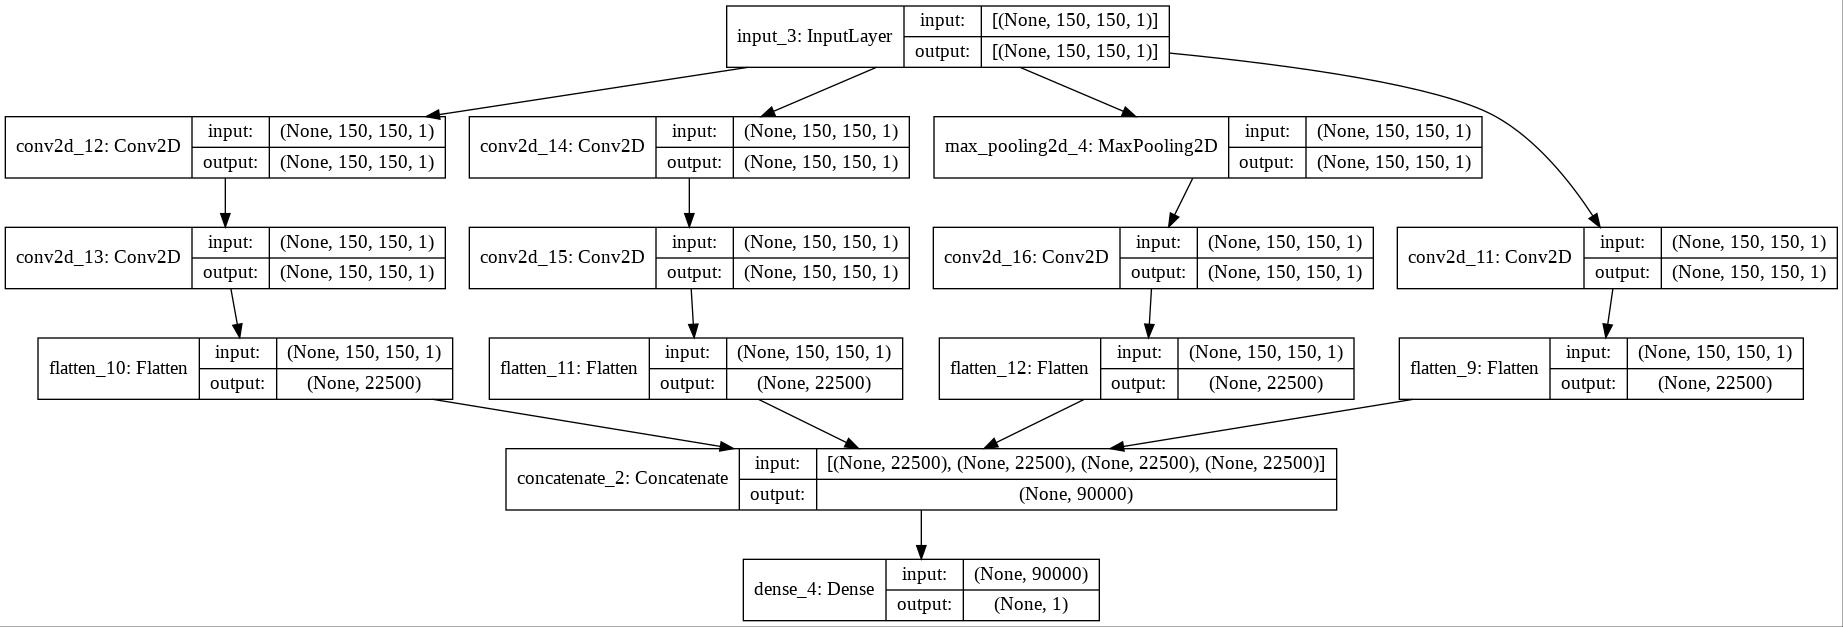

In [66]:
from tensorflow.keras.utils import plot_model

plot_model(model_CNN6, to_file='6.jpg', show_shapes=True)